# Empirical analysis of the 5G coverage 

#### Imports

In [86]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import scikit_posthocs as sp
import seaborn as sns
from scipy.stats import kstest, spearmanr

#### Dataset

In [87]:
df_4g = pd.read_csv('datasets/4G-Passive-Measurements.csv')

In [88]:
print(df_4g.columns)
df = df_4g[['RSRP', 'Speed', 'distance', 'Latitude', 'Longitude', 'scenario', 'MNC', 'campaign', 'Time']]
df = df[(df['RSRP'] >= -144) & (df['RSRP'] <= -44)]  # remove impossible values 
df = df[(df['scenario'] == 'OD') | (df['scenario'] == 'IS')]
df = df.replace('"Op"[1]', 'Op1')
df = df.replace('"Op"[2]', 'Op2')
print(df.head())

Index(['Unnamed: 0', 'Date', 'Time', 'UTC', 'Latitude', 'Longitude',
       'Altitude', 'Speed', 'EARFCN', 'Frequency', 'PCI', 'MNC',
       'CellIdentity', 'eNodeB.ID', 'Power', 'SINR', 'RSRP', 'RSRQ',
       'scenario', 'cellLongitude', 'cellLatitude', 'cellPosErrorLambda1',
       'cellPosErrorLambda2', 'n_CellIdentities', 'distance', 'Band',
       'campaign'],
      dtype='object')
        RSRP  Speed    distance   Latitude  Longitude scenario  MNC  \
9629  -87.19   3.60  681.668663  41.893101  12.494476       IS  Op1   
9630  -93.24   3.60  154.023876  41.893101  12.494476       IS  Op1   
9631  -85.16   1.26  679.486796  41.893141  12.494451       IS  Op1   
9632  -89.99   1.26  156.301756  41.893141  12.494451       IS  Op1   
9633 -115.25   1.26  273.746723  41.893141  12.494451       IS  Op1   

                         campaign          Time  
9629  campaign_35_IS_4G_speedtest  10:49:35.850  
9630  campaign_35_IS_4G_speedtest  10:49:35.850  
9631  campaign_35_IS_4G_speedtest

In [89]:
op1_is = df[(df['scenario'] == 'IS') & (df['MNC'] == "Op1")]
op1_od = df[(df['scenario'] == 'OD') & (df['MNC'] == "Op1")]
op2_is = df[(df['scenario'] == 'IS') & (df['MNC'] == "Op2")]
op2_od = df[(df['scenario'] == 'OD') & (df['MNC'] == "Op2")]

print(op1_od.head())
print(op1_is.shape, op1_od.shape, op2_is.shape, op2_od.shape)

         RSRP  Speed    distance   Latitude  Longitude scenario  MNC  \
14168  -92.64   2.59  140.986376  41.866440  12.530809       OD  Op1   
14172 -108.02  22.07  168.332515  41.866187  12.530826       OD  Op1   
14173  -96.76  22.07  168.332515  41.866187  12.530826       OD  Op1   
14177  -96.31  32.58  218.432923  41.865719  12.530988       OD  Op1   
14179 -106.81  30.46  234.582894  41.865571  12.531048       OD  Op1   

                          campaign          Time  
14168  campaign_10_OD_4G_speedtest  17:26:19.536  
14172  campaign_10_OD_4G_speedtest  17:26:26.362  
14173  campaign_10_OD_4G_speedtest  17:26:26.362  
14177  campaign_10_OD_4G_speedtest  17:26:34.566  
14179  campaign_10_OD_4G_speedtest  17:26:35.532  
(89597, 9) (41115, 9) (127054, 9) (42902, 9)


### Create violin plots to inspect distributions

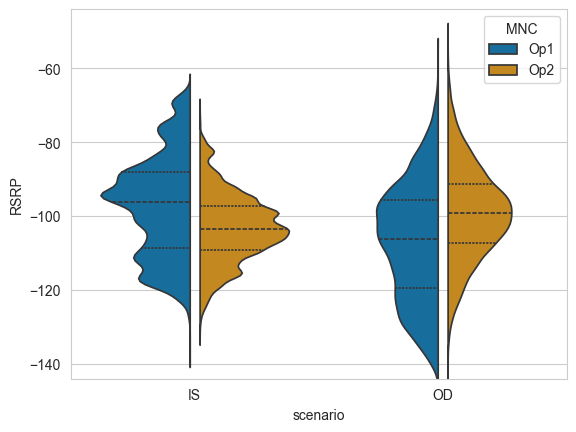

In [90]:
sns.violinplot(x='scenario', y='RSRP', hue='MNC', data=df, split=True, gap=0.1, inner='quart', palette='colorblind')
## lines show the quartiles of the data
sns.set_style('whitegrid')
plt.ylim(-144, -44)
plt.show()

In [91]:
df_4g = df_4g[(df_4g['RSRP'] >= -144) & (df_4g['RSRP'] <= -44) &
              (df_4g['RSRQ'] >= -19.5) & (df_4g['RSRQ'] <= -3) &
              (df_4g['SINR'] >= -20) & (df_4g['SINR'] <= 20)]
df_4g = df_4g.fillna(0)

### Statistical analysis

In [92]:
# test for normal distribution
_, p_op1_is = kstest(op1_is['RSRP'], 'norm')
_, p_op1_od = kstest(op1_od['RSRP'], 'norm')
_, p_op2_is = kstest(op2_is['RSRP'], 'norm')
_, p_op2_od = kstest(op2_od['RSRP'], 'norm')

print(f'Statistical results for testing for normal distribution are:\n'
      f'Operator 1, IS: {p_op1_is:.3f}\n'
      f'Operator 1, OD: {p_op1_od:.3f}\n'
      f'Operator 2, IS: {p_op2_is:.3f}\n'
      f'Operator 2, OD: {p_op2_od:.3f}')

Statistical results for testing for normal distribution are:
Operator 1, IS: 0.000
Operator 1, OD: 0.000
Operator 2, IS: 0.000
Operator 2, OD: 0.000


All test show p-values < 0.001, rejecting the null-hypothesis of a normal distribution.
Therefore, for futher statistical testing, non-parametric tests need to be used.

In [93]:
n_test = 4  # bonferroni correction on multiple comparisons
data = [op1_is['RSRP'], 
        op1_od['RSRP']]
p_op1_isvod = sp.posthoc_dunn(data) * n_test

data = [op2_is['RSRP'],
        op2_od['RSRP']]
p_op2_isvod = sp.posthoc_dunn(data) * n_test

data = [op1_is['RSRP'], 
        op2_is['RSRP']]
p_is_1v2 = sp.posthoc_dunn(data) * n_test

data = [op1_od['RSRP'],
        op2_od['RSRP']]
p_od_1v2 = sp.posthoc_dunn(data) * n_test


print(f"Statistical test results from Dunn's test while using a Bonferroni correction based on {n_test} tests:\n"
      f"Operator 1, IS vs. OD: {p_op1_isvod.iloc[0, 1]:.3f}\n"
      f"Operator 2, IS vs. OD: {p_op2_isvod.iloc[0, 1]:.3f}\n"
      f"Operator 1 vs. Operator 2, IS: {p_is_1v2.iloc[0, 1]:.3f}\n"
      f"Operator 1 vs. Operator 2, OD: {p_od_1v2.iloc[0, 1]:.3f}")

Statistical test results from Dunn's test while using a Bonferroni correction based on 4 tests:
Operator 1, IS vs. OD: 0.000
Operator 2, IS vs. OD: 0.000
Operator 1 vs. Operator 2, IS: 0.000
Operator 1 vs. Operator 2, OD: 0.000


All tests show p-values < 0.001, rejecting the null-hypothesis that the samples come from the same distribution.

### Correlation tests
Check for correlation between speed, distance, and location, and RSRP value while driving.
Should we look for correlations in the entire dataset or for each subset (Operator and scenario)?

<Axes: xlabel='RSRP', ylabel='Count'>

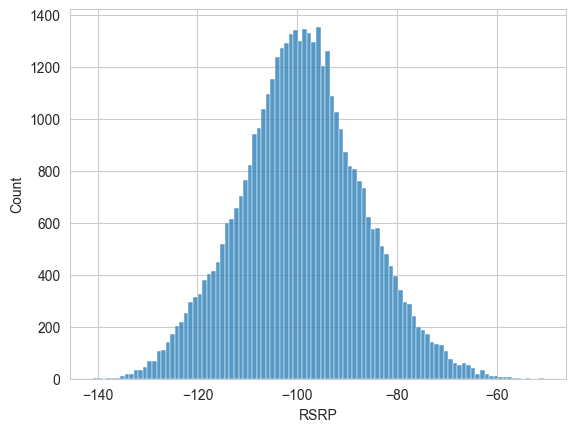

In [94]:
# sns.scatterplot(x=op1_od['Speed'], y=op1_od['RSRP'])
# sns.scatterplot(x=op1_od['distance'], y=op1_od['RSRP'])
# sns.scatterplot(x=op1_od['Latitude'], y=op1_od['RSRP'])
# sns.scatterplot(x=op1_od['Longitude'], y=op1_od['RSRP'])
sns.histplot(op2_od['RSRP'])

In [95]:
res_op1_speed = spearmanr(op1_od['RSRP'], op1_od['Speed'])
res_op2_speed = spearmanr(op2_od['RSRP'], op2_od['Speed'])
print(f'Results of Spearman correlation tests for RSRP and Speed:\n'
      f'Operator 1: {res_op1_speed.statistic:.3f}, {res_op1_speed.pvalue:.3f}\n'
      f'Operator 2: {res_op2_speed.statistic:.3f}, {res_op2_speed.pvalue:.3f}')

Results of Spearman correlation tests for RSRP and Speed:
Operator 1: -0.055, 0.000
Operator 2: -0.068, 0.000


In [96]:
res_dis_op1_is = spearmanr(op1_is['RSRP'], op1_is['distance'])
res_dis_op1_od = spearmanr(op1_od['RSRP'], op1_od['distance'])
res_dis_op2_is = spearmanr(op2_is['RSRP'], op2_is['distance'])
res_dis_op2_od = spearmanr(op2_od['RSRP'], op2_od['distance'])

print(f'Results of Spearman correlation tests for RSRP and distance:\n'
      f'Operator 1, IS: {res_dis_op1_is.statistic:.3f}, {res_dis_op1_is.pvalue:.3f}\n'
      f'Operator 1, OD: {res_dis_op1_od.statistic:.3f}, {res_dis_op1_od.pvalue:.3f}\n'
      f'Operator 2, IS: {res_dis_op2_is.statistic:.3f}, {res_dis_op2_is.pvalue:.3f}\n'
      f'Operator 2, OD: {res_dis_op2_od.statistic:.3f}, {res_dis_op2_od.pvalue:.3f}\n')

Results of Spearman correlation tests for RSRP and distance:
Operator 1, IS: -0.074, 0.000
Operator 1, OD: -0.560, 0.000
Operator 2, IS: 0.117, 0.000
Operator 2, OD: -0.310, 0.000



           Speed  Distance
Op1_IS       NaN -0.074205
Op1_OD -0.055363 -0.559601
Op2_IS       NaN  0.116520
Op2_OD -0.068257 -0.309919


[Text(0, 0.5, 'Op1_IS'),
 Text(0, 1.5, 'Op1_OD'),
 Text(0, 2.5, 'Op2_IS'),
 Text(0, 3.5, 'Op2_OD')]

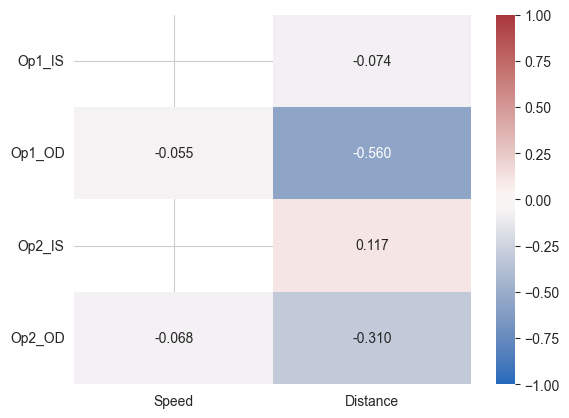

In [25]:
groups = ['Op1_IS', 'Op1_OD', 'Op2_IS', 'Op2_OD']
data = {'Speed': [np.nan, res_op1_speed.statistic, np.nan, res_op2_speed.statistic],
        'Distance': [res_dis_op1_is.statistic, res_dis_op1_od.statistic, res_dis_op2_is.statistic, res_dis_op2_od.statistic]}
correlations = pd.DataFrame(data, index=groups)
print(correlations)
ax = sns.heatmap(correlations, vmin=-1, vmax=1, annot=True, fmt=".3f", cmap='vlag')
ax.set_yticklabels(labels=groups, rotation=0)


### What can we do in the assignment?

* Could it be an idea to look at the correlation between signal strength and number of PCIs connected to the unit (4g dataset)?
* Alternatively, look into the different kinds of RSRPs in the 5g dataset and do a kind of time analysis?
* Or something completely different? I don't really know what could be possible and is easy enough to do in 1,5 weeks lol

In [97]:
def Pearson_correlation(X,Y):
    if len(X)==len(Y):
        Sum_xy = sum((X-X.mean())*(Y-Y.mean()))
        Sum_x_squared = sum((X-X.mean())**2)
        Sum_y_squared = sum((Y-Y.mean())**2)       
        corr = Sum_xy / np.sqrt(Sum_x_squared * Sum_y_squared)
    return corr

print(f'Pearson correlation between RSRP and distance: ', Pearson_correlation(df['RSRP'], df['distance']))
print(f'Pearson correlation between RSRP and speed: ', Pearson_correlation(df['RSRP'], df['Speed']))


Pearson correlation between RSRP and distance:  -0.29693102644303176
Pearson correlation between RSRP and speed:  nan


<Axes: >

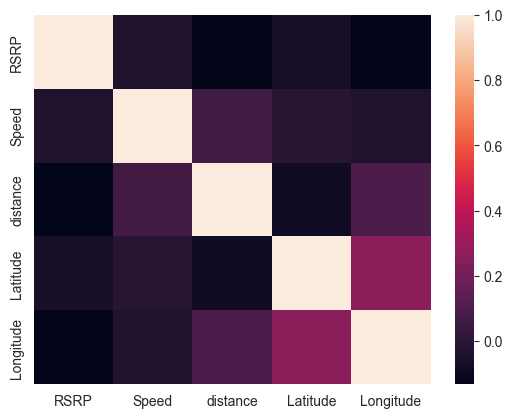

In [98]:
df_numeric_features_only = df.select_dtypes(include=np.number)
corr = df_numeric_features_only.corr(method = 'spearman')
sns.heatmap(corr)

In [99]:
long_drive = 'campaign_56_OD_4G'
trip_op1 = df[(df['campaign'] == long_drive) & (df['MNC'] == 'Op1')]
trip_op2 = df[(df['campaign'] == long_drive) & (df['MNC'] == 'Op2')]

fig = go.Figure()

scl = [0,"rgb(150,0,90)"],[0.125,"rgb(0, 0, 200)"],[0.25,"rgb(0, 25, 255)"],\
[0.375,"rgb(0, 152, 255)"],[0.5,"rgb(44, 255, 150)"],[0.625,"rgb(151, 255, 0)"],\
[0.75,"rgb(255, 234, 0)"],[0.875,"rgb(255, 111, 0)"],[1,"rgb(255, 0, 0)"]

fig.add_trace(go.Scattermapbox(lat=trip_op1['Latitude'], lon=trip_op1['Longitude'],
    marker = dict(
        color = trip_op1['RSRP'],
        colorscale = scl,
        reversescale = True,
        opacity = 0.7,
        size = 5.5,
        colorbar = dict(
            titleside = "right",
            outlinecolor = "rgba(68, 68, 68, 0)",
        )
    )))
fig.update_layout(
    height=600,
    mapbox=dict(
        style='carto-darkmatter',
        zoom=12.8,
        center=dict(lon=trip_op1['Longitude'].mean(), lat=trip_op1['Latitude'].mean())
    ),
    margin=dict(
        t=0,
        b=0,
        r=0,
        l=0
    )
)
fig.show()

In [100]:
fig = go.Figure()

scl = [0,"rgb(150,0,90)"],[0.125,"rgb(0, 0, 200)"],[0.25,"rgb(0, 25, 255)"],\
[0.375,"rgb(0, 152, 255)"],[0.5,"rgb(44, 255, 150)"],[0.625,"rgb(151, 255, 0)"],\
[0.75,"rgb(255, 234, 0)"],[0.875,"rgb(255, 111, 0)"],[1,"rgb(255, 0, 0)"]

fig.add_trace(go.Scattermapbox(lat=trip_op2['Latitude'], lon=trip_op2['Longitude'],
    marker = dict(
        color = trip_op2['RSRP'],
        colorscale = scl,
        reversescale = True,
        opacity = 0.7,
        size = 5.5,
        colorbar = dict(
            titleside = "right",
            outlinecolor = "rgba(68, 68, 68, 0)",
        )
    )))
fig.update_layout(
    height=600,
    mapbox=dict(
        style='carto-darkmatter',
        zoom=12.8,
        center=dict(lon=trip_op2['Longitude'].mean(), lat=trip_op2['Latitude'].mean())
    ),
    margin=dict(
        t=0,
        b=0,
        r=0,
        l=0
    )
)
fig.show()

In [101]:
trip_op1['Time']

387004    15:24:33.965
387005    15:24:33.965
387006    15:24:34.062
387007    15:24:35.895
387008    15:24:36.638
              ...     
392810    15:50:28.754
392811    15:50:28.754
392812    15:50:28.754
392813    15:50:28.754
392814    15:50:28.754
Name: Time, Length: 3053, dtype: object

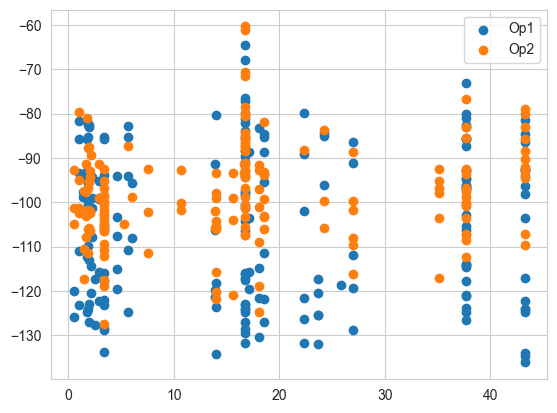

In [102]:
short_drive = 'campaign_52_OD_4G'
drive_op1 = df[(df['campaign'] == short_drive) & (df['MNC'] == 'Op1')]
drive_op2 = df[(df['campaign'] == short_drive) & (df['MNC'] == 'Op2')]

plt.scatter(drive_op1['Speed'], drive_op1['RSRP'])
plt.scatter(drive_op2['Speed'], drive_op2['RSRP'])
plt.legend(['Op1', 'Op2'])